# Polynomial and Decision Tree Regression on the Pantheon+ dataset

This notebook will showcase using regression models from the scikit-learn module to predict apparent magnitudes using more features than what is done in the visualization notebook. We begin by importing the necessary modules and data.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import os
import sys
sys.path.append('../src')
from preprocessing import preprocessor_simple, preprocess_des_data

pantheonpluspath = '../data/Pantheon+SH0ES.dat'

X1,y1 = preprocessor_simple(pantheonpluspath)
X_train, X_valid, y_train, y_valid = train_test_split(X1,y1,test_size = 0.3,random_state = 0)

## Polynomial Regression

We can start with the Polynomial regressor. We can set up a simple 3rd degree polynomial regression.

In [3]:
poly1 = PolynomialFeatures(degree = 3, include_bias = False)

poly_features = poly1.fit_transform(X_train)

poly_model = LinearRegression()

poly_model.fit(poly_features,y_train)

ypred = poly_model.predict(poly1.transform(X_valid))
mae3d = mean_absolute_error(y_valid, ypred)


print(f'MAE for polynomial fit with a 3 degree polynomial : {mae3d}')
# print(ypred)
# print(y1)
# y1.head()

# plt.scatter(X_train['zHD'],y_train)
# plt.plot(X_valid,ypred)


MAE for polynomial fit with a 3 degree polynomial : 0.6831737322330402


## Decision Tree

We will start with a Decision Tree Regressor.

In [4]:

decTree = DecisionTreeRegressor(random_state = 0)
decTree.fit(X_train,y_train)

y_pred_decTree = decTree.predict(X_valid)

mae_decTree = mean_absolute_error(y_valid,y_pred_decTree)
print(f'MAE for a Decision Tree Regressor : {mae_decTree}')

MAE for a Decision Tree Regressor : 0.1592869863013698


Right now, the Decision Tree looks like a better choice to predict the absolute magnitude of Type Ia supernovae from the redshift, stretch color and... We will fit some higher order polynomials to check if the MAE of the polynomial regressor improves.

In [9]:
def polynomial_fitter(X,y,degree):
    poly1 = PolynomialFeatures(degree = degree,include_bias = False)
    poly_features = poly1.fit_transform(X)
    poly_model = LinearRegression()
    poly_model.fit(poly_features,y)
    return poly_model,poly1
    
def maeforpoly(X_train,y_train,X_valid,y_valid,degree):
    # poly1 = PolynomialFeatures(degree = degree,include_bias = False)
    poly_model,poly1 = polynomial_fitter(X_train,y_train,degree)
    ypreds = poly_model.predict(poly1.transform(X_valid))
    return mean_absolute_error(y_valid,ypreds)
degreevals = np.linspace(2,12,11, dtype = 'int64')
print(degreevals)
for i in degreevals:
    print(f'MAE for a polynomial fit of degree {i} : {maeforpoly(X_train,y_train,X_valid,y_valid,i)}')

[ 2  3  4  5  6  7  8  9 10 11 12]
MAE for a polynomial fit of degree 2 : 0.9910553371918874
MAE for a polynomial fit of degree 3 : 0.6831737322330402
MAE for a polynomial fit of degree 4 : 0.5399037633752826
MAE for a polynomial fit of degree 5 : 0.44967846444245024
MAE for a polynomial fit of degree 6 : 0.4979908839239662
MAE for a polynomial fit of degree 7 : 0.9719012796887476
MAE for a polynomial fit of degree 8 : 2.810116353956823
MAE for a polynomial fit of degree 9 : 12.319525100429475
MAE for a polynomial fit of degree 10 : 82.76626679452838
MAE for a polynomial fit of degree 11 : 127.8432283311131
MAE for a polynomial fit of degree 12 : 1126.1995839173442


We can check the performance of the two models in predicting the values of the validation set.

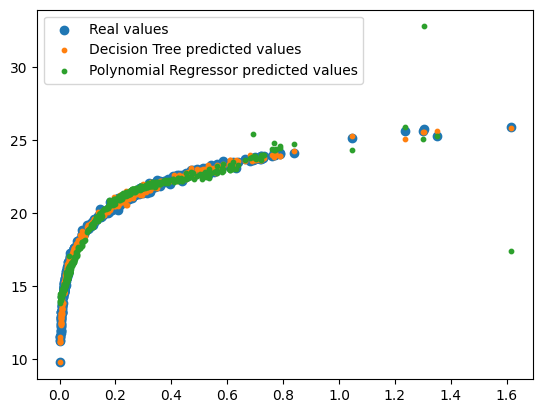

In [16]:
d5fitter,d5transform = polynomial_fitter(X_train,y_train,5)

ypred_d5 = d5fitter.predict(d5transform.transform(X_valid))

plt.scatter(X_valid['zHD'],y_valid, label = 'Real values')
plt.scatter(X_valid['zHD'],y_pred_decTree, label = 'Decision Tree predicted values', s = 10)
plt.scatter(X_valid['zHD'],ypred_d5, label = 'Polynomial Regressor predicted values', s = 10)
plt.legend()


## Validation

We can see that the the fit is best when we choose a polynomial of degree 5 as it gives the least MAE, but the Decision Tree makes beter predictions than even the degree 5 polynomial regressor. But this is from the same Pantheon+ dataset. To validate these models in a more robust manner, we need to test it against a different dataset. For this, I will be using the Dark Energy Survey 5 Year Data release supernova dataset, which contains data of 1829 supernovae.

In [6]:
despath = '../data/DES-data.csv'
X_test,y_test = preprocess_des_data(despath)
decTree2 = DecisionTreeRegressor(random_state = 0)
decTree2.fit(X1,y1)

y_pred_decTree2 = decTree2.predict(X_test)
maetest_decTree2 = mean_absolute_error(y_test,y_pred_decTree2)

print(f'MAE for Decision Tree with test data : {maetest_decTree2}')

MAE for Decision Tree with test data : 0.2167447785675233


In [7]:

for i in degreevals:
    print(f'MAE for polynomial fit of degree {i} with test data : {maeforpoly(X1,y1,X_test,y_test,i)}')

MAE for polynomial fit of degree 2 with test data : 1.042815292581271
MAE for polynomial fit of degree 3 with test data : 0.611420687102262
MAE for polynomial fit of degree 4 with test data : 0.5344639368609961
MAE for polynomial fit of degree 5 with test data : 0.5424599903285149
MAE for polynomial fit of degree 6 with test data : 0.5856359710730267
MAE for polynomial fit of degree 7 with test data : 1.071674408338332
MAE for polynomial fit of degree 8 with test data : 2.0632098118930333
MAE for polynomial fit of degree 9 with test data : 9.338612175790818
MAE for polynomial fit of degree 10 with test data : 13.062360653157075
MAE for polynomial fit of degree 11 with test data : 43.26010207899929
MAE for polynomial fit of degree 12 with test data : 190.75490686012068


We can finally check the predicted values with the real values from the data as well.

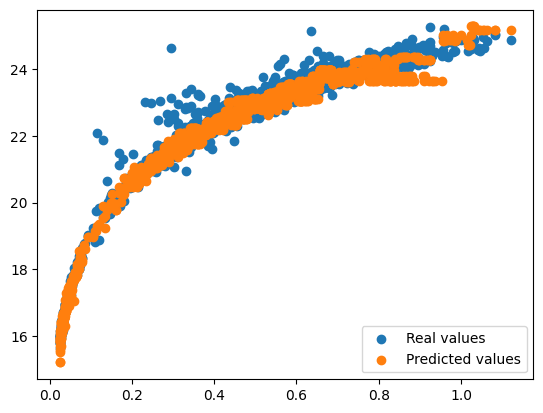

In [8]:
plt.scatter(X_test['zHD'],y_test, label = 'Real values')
plt.scatter(X_test['zHD'],y_pred_decTree2, label = 'Predicted values')
plt.legend()

## Conclusion

We can conclude that the Decision Tree Regressor proves to be a better model to predict absolute magnitudes of supernovae from these three features. Polynomial Regression with a polynomial of degree 5 also seem to give really good results.